# Лекция 12. Потоки. Межпроцессное взаимодействие.

1. Понятие потока, многопоточность, потоки на уровне ядра, на уровне пользователя, конкурентность, параллелизм, гонки
2. Создание многопоточных приложений
3. Межпроцессное взаимодействие с использованием анонимного отображения в память, с использованием каналов
4. Синхронизация процессов. Семафоры

## 1. Понятие потока, многопоточность, потоки на уровне ядра, на уровне пользователя, конкурентность, параллелизм, гонки

Ранее мы рассмотрели системный вызов **fork**, который создает полную копию родительского процесса, копируя в том числе все адресное пространство, стек, файловые дескрипторы. 

Таким образлм, системный вызов fork() порождает полностью независимый процесс, который может существовать, даже если родительский процесс завершит свою работу. У дочернего процесса свой PID и полностью свои данные. Операция создания полной копии занимают достаточно времени. И хотя в современных системах Linux реализуется отложенное копирование при попытке первой записи, все же часто возникает необходимость клонировать процесс, но оставить его в рабочем окружении родительского процесса, т.е. адресное пространство, файловые дескрипторы не копируются, а просто остаются теми же. В этом случае мы приходим к понятию **потока**.

**Поток** - это элемент выполнения внутри процесса: виртуальный процессор и стек, имеющий общий доступ к адресному пространству самого процесса. 

С точки зрения планировщика заданий поток - это минимальный элемент, с которым приходится иметь дело. Кроме термина **поток**, часто употребляются синонимы **тред** (thread), **нить**, **легковесный процесс**.


Процесс содержит один или несколько потоков. Если процесс содержит только один поток, то в процессе находится лишь один исполняемый элемент и только одна задача выполняется в единицу времени. Такие процессы можно назвать **однопоточными**. Это классические процессы Linux. 

Если процесс содержит более одного потока, значит одновременно выполняется несколько действий. Такие процессы называются **многопоточными**.

При использовании нескольких потоков управления можно спроектировать приложение, которое будет решать одновременно несколько задач в рамках единственного процесса, где каждый поток решает отдельную задачу. 

Такой подход имеет следующие преимущества.
- Можно значительно упростить код, обрабатывающий асинхронные события, привязав каждый тип события к отдельному потоку. В результате каждый поток сможет обслуживать свое событие.
- Чтобы организовать совместный доступ нескольких процессов к одним и тем же ресурсам, таким как общая память или файловые дескрипторы, не нужно проводить сложных синхронизаций разных процессов, поскольку потоки автоматически получают доступ к одному и тому же адресному пространству и файловым дескрипторам.
- Решение некоторых задач можно разбить на более мелкие подзадачи, что может дать прирост производительности программы. Однопоточный процесс, выполняющий решение нескольких задач, неявно вынужден решать их последовательно, поскольку имеет только один поток управления. При наличии нескольких потоков управления независимые друг от друга задачи могут решаться одновременно отдельными потоками. Две задачи могут решаться одновременно только при условии, что они не зависят друг от друга.
- Аналогично, интерактивные программы могут сократить время отклика на действия пользователя, используя многопоточную модель, чтобы отделить обработку ввода/вывода пользователя от других частей программы.

У многих многопоточное программирование ассоциируется с многопроцессорными системами. Однако преимущества многопоточной модели проявляют себя, даже если программа работает в однопроцессорной системе. Независимо от количества процессоров, программу можно упростить благодаря многопоточной модели, поскольку количество процессоров не влияет на структуру программы. Кроме того, в то время как однопоточный процесс вынужден периодически простаивать при последовательном решении нескольких задач, многопоточный может повысить производительность и в однопроцессорной системе, так как часть потоков могут продолжать работу, когда другие простаивают, ожидая наступления некоторых событий.

Несмотря на все свои преимущества, многопоточность все-таки сопряжена с некоторыми издержками. 

Разработка, написание, понимание и отладка многопоточных программ значительно сложнее, чем однопоточных процессов.

Источник опасности потоков непосредственно заключается в том, что несколько виртуальных процессоров существуют при только одном экземпляре виртуальной памяти. 

Иными словами, при многопоточном процессе выполняется одновременно несколько действий (параллелизм), разделяющих одну и ту же область памяти. Таким образом, неизбежно, что потоки в процессе делят между собой ресурсы — им нужно считать или записать одни и те же данные с непредсказуемым выбором времени выполнения этих действий. Сбой в синхронизации может перевести к перекрытию вывода, некорректному выполнению и прекращению работы программы. 


Одно из преимуществ производительности происходит от уменьшения затрат на переключение от потока к потоку внутри одного и того же процесса (внутрипроцессорное переключение). В любой системе ресурсные издержки внутрипроцессорного переключения меньше, чем переключения между процессами; первое в любом случае входит во второе. Эта разница в затратах особенно велика в системах, отличающихся от Linux, где процессы являются абстракциями, поэтому во многих системах потоки называются **легковесными процессами**.

В Linux затраты на переключение между процессами невелики, но стоимость переключения внутри процесса близка к нулю: по сути, она равна входу и выходу из ядра. Процессы незатратны, но потоки все равно экономнее.

Машинная архитектура приводит к большим издержкам на переключение. На х86, например, буфер ассоциативной
трансляции (TLB), являющийся отображением кэша физической оперативной памяти, должен быть очищен от виртуального адресного пространства. При определенных рабочих нагрузках потери TLB весьма значительно ухудшают системную производительность. Самый экстремальный пример наблюдается на машинах ARM, где необходимо очищать содержимое процессорного кэша! Потоков не касаются
эти затраты, поскольку переключение от потока к потоку не требует очищения виртуального адресного пространства.


Существует несколько подходов к реализации поточности в системе, с различной степенью функциональности, **обеспечиваемой ядром и пользовательским пространством**. 

Самая простая модель заключается в том, что ядро обеспечивает свою встроенную поддержку потоков, и каждый из них напрямую отправляет в пользовательское пространство свою информацию. Такая модель называется поточностью 1:1, поскольку в ней присутствует соотношение 1:1 между тем, что предоставляет ядро, и тем, что получает пользователь. Эта модель также известна как **поточность на
уровне ядра**, поскольку ядро является основой системной поточной модели.

Поточность в Linux является поточностью 1:1. **Ядро Linux реализует потоки просто как процессы, разделяющие между собой ресурсы.**

Новый поток создается через системный вызов **clone()**. Таким образом в Linux то, что является потоком в пользовательском пространстве, в целом является тем же самым и с точки зрения ядра.

Полностью противоположная модель — поточность N:1, также называемая **поточностью на уровне пользователя**. В отличие от поточности на уровне ядра, в этой модели пользовательское пространство — основа системной поддержки поточности, поскольку именно оно реализует поток. **Процесс с N потоками приведет к одному процессу в ядре** — вот почему модель называется N:1. Эта модель
(почти) не требует поддержки ядра, но для нее нужно достаточно много кода в пользовательском пространстве, включая планировщик в пользовательском пространстве для планирования потоков и механизм для отлавливания и обработки ввода-вывода без блокирования.

Преимущество потоков на уровне пользователя заключается в том, что переключение контекста почти не требует ресурсов, поскольку приложение само может решать, какой поток нужно запустить и когда без участия ядра. Недостатком можно назвать то, что только один элемент в ядре поддерживает N потоков, из-за чего модель не может использовать N процессоров и, следовательно, истинный параллелизм.  На современном аппаратном обеспечении это весьма значительный недостаток.

Из-за потоков появляется два взаимосвязанных явления: **конкурентность и параллелизм**. 

**Конкурентность** - способность двух и более потоков выполняться в перекрывающиеся периоды времени. 

**Параллелизм** — способность выполнять два и более потока одновременно. 

Конкурентность может происходить и без параллелизма, например, в однопроцессорной системе. Параллелизм (иногда подчеркивается — истинный параллелизм) — особая форма конкурентности, требующая нескольких процессоров. 

При параллелизме потоки выполняются параллельно в буквальном смысле, позволяя многопоточным программам использовать несколько процессоров.

Именно конкурентность вызывает большинство сложностей в поточности. При одновременной работе потоки могут выполняться в непредсказуемом порядке друг относительно друга. В какие-то моменты это прекрасно. Однако что, если потокам придется делить между собой ресурсы? Доступ даже к такой простой вещи, как слово в памяти, становится «гонкой», и поведение программы может быть разным в зависимости от того, какой поток оказался «расторопнее».

Формально **условиями гонки** называется ситуация, когда несинхронизированный доступ к общему ресурсу для двух и более потоков приводит к ошибочному поведению программы.

Окно программного кода, в котором может произойти такая гонка называется **критической областью**. Гонки устраняются путем синхронизации кода в критических областях. 

## 2. Создание многопоточных приложений

Для создания потока, как уже было сказано, используется системный вызов **clone**.

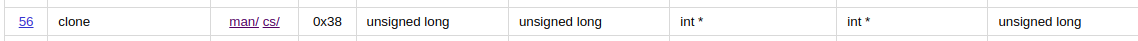

Несмотря на большое количество параметров этом системный вызов работает с двумя параметрами

> long clone(unsigned long flags, void *child_stack);

**Первым аргументом** указывается маска флагов, позволяющая установить, что именно является общим между вызывающим процессом и дочерним процессом. Маска формируется как побитовое **ИЛИ** из зарезервированных констант. 

Флагов довольно много, их полное описание можно найти на странице [руководства](https://man7.org/linux/man-pages/man2/clone.2.html), а также в заголовочном файле /usr/include/linux/sched.h

In [ ]:
#define CSIGNAL		0x000000ff	/* signal mask to be sent at exit */
#define CLONE_VM	0x00000100	/* set if VM shared between processes */
#define CLONE_FS	0x00000200	/* set if fs info shared between processes */
#define CLONE_FILES	0x00000400	/* set if open files shared between processes */
#define CLONE_SIGHAND	0x00000800	/* set if signal handlers and blocked signals shared */
#define CLONE_PIDFD	0x00001000	/* set if a pidfd should be placed in parent */
#define CLONE_PTRACE	0x00002000	/* set if we want to let tracing continue on the child too */
#define CLONE_VFORK	0x00004000	/* set if the parent wants the child to wake it up on mm_release */
#define CLONE_PARENT	0x00008000	/* set if we want to have the same parent as the cloner */
#define CLONE_THREAD	0x00010000	/* Same thread group? */
#define CLONE_NEWNS	0x00020000	/* New mount namespace group */
#define CLONE_SYSVSEM	0x00040000	/* share system V SEM_UNDO semantics */
#define CLONE_SETTLS	0x00080000	/* create a new TLS for the child */
#define CLONE_PARENT_SETTID	0x00100000	/* set the TID in the parent */
#define CLONE_CHILD_CLEARTID	0x00200000	/* clear the TID in the child */
#define CLONE_DETACHED		0x00400000	/* Unused, ignored */
#define CLONE_UNTRACED		0x00800000	/* set if the tracing process can't force CLONE_PTRACE on this clone */
#define CLONE_CHILD_SETTID	0x01000000	/* set the TID in the child */
#define CLONE_NEWCGROUP		0x02000000	/* New cgroup namespace */
#define CLONE_NEWUTS		0x04000000	/* New utsname namespace */
#define CLONE_NEWIPC		0x08000000	/* New ipc namespace */
#define CLONE_NEWUSER		0x10000000	/* New user namespace */
#define CLONE_NEWPID		0x20000000	/* New pid namespace */
#define CLONE_NEWNET		0x40000000	/* New network namespace */
#define CLONE_IO		0x80000000	/* Clone io context */

In [3]:
CLONE_VM=0x00000100
CLONE_FS=0x00000200
CLONE_FILES=0x00000400
CLONE_SIGHAND=0x00000800
CLONE_PARENT=0x00008000
CLONE_THREAD=0x00010000
CLONE_IO=0x80000000

THREAD_FLAGS=CLONE_VM|CLONE_FS|CLONE_FILES|CLONE_SIGHAND|CLONE_PARENT|CLONE_THREAD|CLONE_IO
THREAD_FLAGS

2147585792

Потоки делят между собой все ресурсы, кроме регистров, стека и локального хранилища потока (TLS). Операционная система гарантирует, что регистры будут уникальными внутри потока. На практике стек часто используется для локальных данных потока. Прежде чем мы сможем создать новый поток, нам нужно выделить стек, который является не более чем буфером памяти.

Тривиальный способ сделать это — зарезервировать некоторое фиксированное хранилище для потоков в разделе .bss (с нулевой инициализацией) в самом исполняемом файле. Но в этом случае приложение будет ограничено фиксированным числом потоков. Более корректно выделять память в куче с помощью системного вызова **brk**, или использовать анонимное отображение с помощью **mmap**.

В любом случае, адрес памяти, где располагается стек (точнее вершина стека, на которую указывает **rsp**) задается **вторым параметром** (регистр **rsi**). Важно учитывать, что стек на самом деле растет вниз (в сторону меньших адресов), поэтому в **rsi** нужно загрузить адрес начала памяти плюс ее размер. 

Ниже представлена простейшая программа, в которой поток модифицирует ячейку памяти родительского процесса.

In [ ]:
;;clone_1.asm
format elf64
public _start
include 'func.asm'

THREAD_FLAGS=2147585792

section '.data' writable

place db 0

section '.bss' writable

stack_1 rq 4096 
buffer rb 100

section '.text' executable

_start:

   ;;Печатаем PID родительского процесса
   mov rax, 39
   syscall
   mov rsi, buffer
   call number_str
   call print_str
   call new_line
   
   ;; Создаем новый тред
   
   ;;Устанавливаем флаги
   mov rdi, THREAD_FLAGS
   
   ;;Инициализируем указатель стека
   mov rsi, 4096
   add rsi, stack_1
   
   mov rax, 56
   syscall
   
   ;;Проверяем это дочерний процесс, или родитель
   cmp rax,0
   je new_thread
   
   
   ;;Продолжаем работу в родительском процессе 
   
   ;;Печатаем PID дочернего процесса
   mov rsi, buffer
   call number_str
   call print_str
   call new_line
   
   call input_keyboard
   
   ;;Печатаем значение в ячейке памяти place
   xor rax, rax
   mov al, [place]
   mov rsi, buffer
   call number_str
   call print_str
   call new_line
   call exit
   
;;В треде увеличивается на единицу значение в ячейке памяти place
new_thread:
  xor rax, rax
   mov al, [place]
   inc rax
   mov [place], al
   call exit

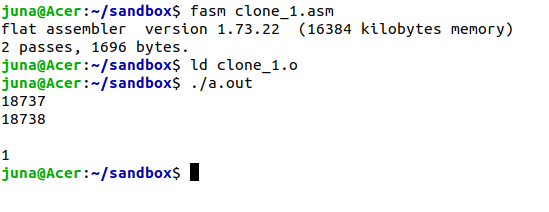

Следующая программа демонстрируем нахождение максимального и минимального кода символа в строке, хранящейся в памяти родительского процесса.

In [ ]:
;;clone_2.asm

format elf64
public _start
include 'func.asm'

THREAD_FLAGS=2147585792


section '.data' writable

max db 0,0
min db 0,0
array db 'abcdefhzw'
len=$-array

section '.bss' writable

stack_1 rq 4096 
stack_2 rq 4096

buffer rb 100

section '.text' executable

_start:

   ;;Запускаем первый тред
   mov rdi, THREAD_FLAGS
   mov rsi, 4096
   add rsi, stack_1
   mov rax, 56
   syscall
   cmp rax,0
   je thread_1
   
   ;;Запускаем второй тред
   mov rdi, THREAD_FLAGS
   mov rsi, 4096
   add rsi, stack_2
   mov rax, 56
   syscall
   cmp rax,0
   je thread_2
   
   ;;Ждем
   call input_keyboard
   
   ;;Печатаем результаты

   mov rsi,min
   call print_str
   call new_line
   
   mov rsi,max
   call print_str
   call new_line
   
   call exit
   
thread_1:
  mov rcx, 0
  xor rdx, rdx
  mov dl, [array]
  .loop_find_min:
  cmp dl, [array+rcx]
  jl .p
  mov dl, [array+rcx]
  .p:
  inc rcx
  cmp rcx, len
  jl .loop_find_min
  mov [min], dl
  call exit 
  
thread_2:
  mov rcx, 0
  xor rdx, rdx
  mov dl, [array]
  .loop_find_max:
  cmp dl, [array+rcx]
  jg .p
  mov dl, [array+rcx]
  .p:
  inc rcx
  cmp rcx, len
  jl .loop_find_max
  mov [max], dl
  call exit

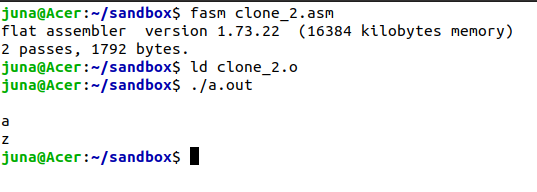

Заметим, однако, что такое выделение памяти под стек не дает возможности запускать динамическое количество процессов. Лучше использовать кучу, или анонимное отображение в память.

Ниже представлена программа использующая анонимное отображение в память. 

Главный процесс запускает заданное количество тредов, выводит их PID, каждый тред  работает асинхронно и выводит сообщение на экран.

In [4]:
MAP_GROWSDOWN=0x0100
MAP_ANONYMOUS=0x0020
MAP_PRIVATE=0x0002
MAP_SHARED = 0x01

hex(MAP_ANONYMOUS | MAP_PRIVATE | MAP_GROWSDOWN)

hex(MAP_ANONYMOUS | MAP_SHARED | MAP_GROWSDOWN)

'0x121'

In [ ]:
;;clone_3.asm

format elf64
public _start
include 'func.asm'

THREAD_FLAGS=2147585792
MAP_GROWSDOWN = 0x0100
MAP_ANONYMOUS = 0x0020
MAP_PRIVATE = 0x0002
PROT_READ = 0x1
PROT_WRITE = 0x2
PROT_EXEC = 0x4
STACK_SIZE = 4096



section '.data' writable

TTL db 10

msg db "Hello, world",0

section '.bss' writable

buffer db 100

section '.text' executable

_start:

   .loop:
   
   ;;Запускаем тред
   
   call stack_create
   add rax, STACK_SIZE
   mov rsi, rax
   mov rdi, THREAD_FLAGS
   mov rax, 56
   syscall
   cmp rax,0
   je thread
   
   ;;Печатаем PID родительского процесса
   mov rsi, buffer
   call number_str
   call print_str
   call new_line
   
   ;;Проверяем условие выхода
   xor rax,rax
   mov al, [TTL]
   dec rax
   mov [TTL], al
   cmp rax,0
   jg .loop
  
   call exit
   
  
 ;;Выделяем стек с использованием анонимного отображения в память
 stack_create:
    mov rdi, 0
    mov rsi, STACK_SIZE
    mov rdx, 0x3
    mov r10, 0x122
    mov r9, 0 
    mov rax, 9
    syscall
    ret
    
;;Выполнение треда
thread:
  mov rsi, msg
  call print_str
  call new_line
  call exit  


Ниже представлен скриншот работы данной программы

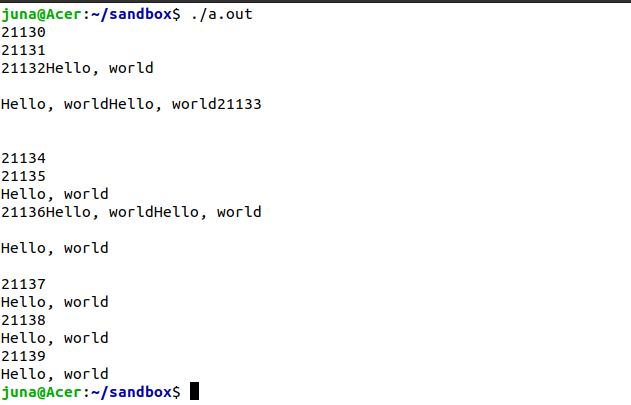

Видно, что треды и родительский процесс работают асинхронно, иногда треды не успевают и выводят сообщения позже родительского процесса или другого треда.

## 3. Межпроцессное взаимодействие с использованием анонимного отображения в память, с использованием каналов

При создании тредов их взаимодействие между собой и родительским процессом весьма просто, т.к. ресурсы у этих процессов общие. Однако возможно взаимодействие и процессов, созданных с помощью системного вызова **fork**. Один из таких механизмов - использование анонимного отображения в память в специальном режиме разделяемой памяти с флагами  **MAP_SHARED = 1**, **MAP_ANONYMOUS**.

Ниже представлена программа, реализующая этот подход. Здесь родительский процесс с помощью вызова **mmap** резервирует одну ячейку памяти, и печатает ее адрес на экране, после этого с помощью **fork** запускается дочерний процесс и родительский процесс переходит в режим ожидания пока значение в ячейке памяти будет отлично от нуля.

Значение в общей разделяемой памяти изменяет дочерний процесс, для этого он вначале ожидает адрес памяти, который нужно изменить. После того, как пользователь вводит этот адрес, он инкрементирует хранящееся там значение и завершает работу (поскольку дочерний процесс полная копия родительского, то адрес этой ячейки конечно же известен и хранится в **address**, так что его можно было бы и не вводить). После этих действий родительский процесс выходит из цикла ожидания, печатает хранящееся в ячейке памяти значение, с помощью вызова **munmap** освобождает разделяемую память и завершает работу.

In [ ]:
;;ipc1.asm
	
format elf64
public _start
include 'func.asm'

section '.data' writable
   
   msg_1 db "First process",0
   msg_2 db "Second process",0
   
	
	
section '.bss' writable
	
	buffer rb 100
	address rq 1
	
	
	
section '.text' executable
	
_start:
    mov rsi, msg_1
    call print_str
    call new_line
    
    ;;Первый процесс создает разделяемую память
    mov rdi, 0    ;начальный адрес выберет сама ОС
    mov rsi, 8    ;задаем размер области памяти
    mov rdx, 0x3  ;совмещаем флаги PROT_READ | PROT_WRITE
    mov r10, 0x21  ;задаем режим MAP_ANONYMOUS|MAP_SHARED
    mov r8, -1   ;указываем файловый дескриптор null
    mov r9, 0     ;задаем нулевое смещение
    mov rax, 9    ;номер системного вызова mmap
    syscall
    
    ;;Сохраняем и печатаем адрес памяти
    mov [address], rax
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    call new_line
    
    ;;Делаем fork процесса
    
    mov rax, 57
    syscall
    cmp rax, 0
    je fork_process
    
    .loop: 
    mov rax, [address]
    mov rcx, [rax]
    cmp rcx, 0
    je .loop
    
    mov rcx, [address]
    mov rax, [rcx]
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
    ;; выполняем системный вызов munmap, освобождая память
    mov rdi, [address]
    mov rsi, 1
    mov rax, 11
    syscall
    call exit
  
  
  fork_process:
    mov rsi, msg_2
    call print_str
    call new_line
    
    mov rsi, buffer
    call input_keyboard
    call str_number
    mov [address], rax
    
    mov rcx, [rax]
    inc rcx
    mov [rax], rcx
    
    call exit

Ниже представлен скриншот работы данной программы:

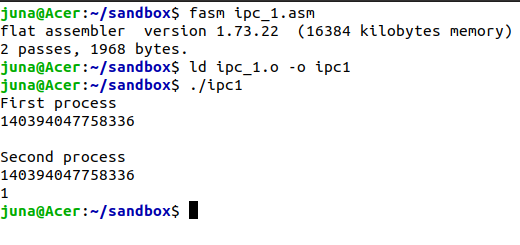

Существуют однако и другие способы межпроцессного взаимодействия (Interprocess Communication) IPC - это **каналы**, точнее **неименованные каналы**( **pipes**).

**Неименованный канал** - это объект ядра, похожий на файл, но обладающий отличием -  при чтении из канала содержимое его удаляется. 

Таким образом канал очень похож на трубу, через которую «течет» информация. Использовать один объект pipe для двустороннего обмена проблематично. В любом случае понадобится дополнительное средство синхронизации. Иначе тот, кто написал в pipe, может прочесть свое же сообщение, и оно не дойдет до адресата. 

Есть еще одно важное отличие каналов от файлов - при создании канала программа получает **два дескриптора (4-байтового числа): для
чтения и записи.** 

**Дескрипторы будут располагаться в памяти друг за другом, в начале для чтения, потом для записи.**

Объект pipе, конечно, можно использовать и в рамках одного процесса. Например, обмен информацией между потоками. Но смысла в
этом большого нет. А вот для взаимодействия между родственными процессами: родитель-дочерний процесс, два дочерних процесса и т.п.
этот механизм может быть очень полезен.

При организации взаимодействия между процессами с помощью объекта pipe следует иметь в виду, что данные передаются не большими
порциями. Поэтому передавать информацию лучше не большими объемами, известными принимающей стороне. Для передачи и чтения данных используются стандартные системные функции **write и read**. 

При этом если канал открыт с одной стороны для записи, то функция read будет ждать передачи. Если нет потенциальных передатчиков информации, то функция возвратит 0.

Если объект pipe открыт в родительском процессе, то при создании дочернего процесса ему передается и таблица открытых объектов. Таким образом, дочерние процессы наследуют объекты pipe и получают возможность обмениваться информацией и с родительсоким процессом и друг с другом. Важно при этом понимать, что все процессы при этом получают два дескриптора: на запись и на чтение. Один из ненужных дескрипторов следует закрыть, чтобы не возникла, например, ситуация, когда функция **read** будет ожидать передачу данных от своего же процесса, а функция **write** будет ждать, когда свой же процесс примет данные. Для двухсторонней же передачи следует просто создать два объекта **pipe**.

Неименованные каналы (pipes, далее для краткости просто каналы) — это старейшая форма организации взаимодействий между процессами, предоставляемая операционными системами UNIX. При использовании каналов имеется ограничение:  каналы могут использоваться только для организации взаимодействий между процессами, которые находятся в родстве (или имеют общего предка, или находятся в отношении родитель-ребенок). Обычно канал создается родительским процессом, который затем вызывает функцию fork, после чего канал может использоваться для общения между родительским и дочерним процессами.

Каждый раз, когда вы вводите в командной строке последовательность команд, объединенных в **конвейер**, оболочка создает отдельный процесс для каждой команды и связывает с помощью канала стандартный вывод предыдущей команды со стандартным вводом следующей.

Неименованный канал создается с помощью системного вызова  **pipe**:

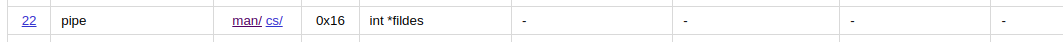

In [ ]:
 #include <unistd.h>

int pipe(int pipefd[2]);

Массив **pipefd** используется для возврата двух файловых дескрипторов, ссылающихся на концы канала: pipefd[0] - дескриптор на чтение из канала, pipefd[1] дескриптор на запись в канал. 

При успешном вызове **pipe** возвращается 0, и по адресу pipefd сохраняются файловые дескрипторы.

Данные, записанные на конец канала буферизируются ядром до тех пор, пока они не будут прочитаны с помощью **read**


Ниже в программе создается объект pipe, а потом дочерний процесс. Далее происходит передача данных от родительского процесса к
дочернему и в качестве подтверждения дочерний процесс выводит полученную строку на консоль. 

In [ ]:
;;ipc_2.asm

format elf64
public _start
include 'func.asm'

section '.data' writable
   
   msg db "Error create pipe",0xa, 0
   pipefd dq 0
   msg_parent db "Hello, my children", 0xa, 0
   len_msg dq 0


section '.bss' writable

    buffer db 100

section '.text' executable

_start:

    ;;Создаем неименованный канал
    mov rax, 22
    mov rdi, pipefd
    syscall
    
    cmp rax,0
    jnl .cont
    mov rsi, msg
    call print_str
    call new_line
    call exit
    
    ;;Создаем дочерний процесс
.cont: 
    mov rax, 57
    syscall
        
    cmp rax, 0
    je .children
    
    ;;закрываем канал на чтение в родительском процессе
    xor rdi, rdi
    mov edi, dword [pipefd]
    mov rax, 3
    syscall 
    
    ;;Определяем длину сообщения
    mov rax, msg_parent
    call len_str
    
    ;;Пишем в канал
    mov rdx, rax
    mov rsi, msg_parent
    xor rdi, rdi
    mov edi, dword [pipefd+4]
    mov rax, 1
    syscall
    
    mov rsi, buffer
    call input_keyboard
    
    ;;закрываем канал на запись родителю
    xor rdi, rdi
    mov edi, dword [pipefd+4]
    mov rax, 3
    syscall
    call exit
  
.children:
     ;;Закрываем канал на запись в дочернем процессе
    xor rdi, rdi
    mov edi, dword [pipefd+4]
    mov rax, 3
    syscall
    
    ;;Читаем из pipe
    xor rdi, rdi
    mov edi, dword [pipefd]
    mov rsi, buffer
    mov rdx, 100
    mov rax, 0
    syscall
    call print_str
    
    ;;закрываем канал на чтение в дочернем процессе
    xor rdi, rdi
    mov edi, dword [pipefd]
    mov rax, 3
    syscall 
    
    call exit

## 4. Синхронизация процессов. Семафоры

Синхронизация процессов одна из самых важных проблем многозадачности. 

Эта задача возникает, когда процессы, в частности, работают с одним и тем же ресурсом. 

Представим, что две программы работают с одним и тем же файлом. Даже если ситуация предельно проста: одна программа пишет, а другая только читает, все равно здесь необходима синхронизация. 

Первая программа меняет содержимое файла, но процесс записи определенной логической порции еще не закончен, а вторая программа уже начинает читать. 

В результате она может получить рассогласованные данные. Значит должна быть некая блокировка, на время, когда одна программа пишет, а вторая читает.

Одним из удобных механизмов синхронизации в операционной системе Linux являются **семафоры**. 

**Семафор** – это счётчик, над которым можно производить две операции: увеличение и уменьшение значения на единицу, при этом операция уменьшения до нулевого значения счётчика является блокирующей.

Представим себе, что после создания семафора к нему имеют доступ два процесса. Значение счетчика вначале равно 1. 

Через специальную функцию доступ получает один процесс и значение счетчика уменьшается до 0. Второй процесс, обратившись к семафору будет находится в состоянии ожидания. 

Когда первый процесс закончит свою работу, он, обратившись к семафору увеличивает значение счетчика на 1. 

Тогда с ресурсом начинает работу второй процесс и пока он работает ресурс будет заблокирован для первого. 

В результате семафор не позволит двум процессам работать одновременно с одним ресурсом. 

Фрагмент программы между декрементом и инкрементом счетчика можно назвать критической
областью. Такой подход легко обобщается на большее количество процессов. Причем возможны два варианта:
1. Из n процессов только один может работать с ресурсом в данный момент времени. Тогда максимальное значение счетчика также будет равно 1.
2. Но задачу можно поставить и по-другому. Например, разрешить работать одновременно m процессам. Тогда максимальное значение счетчика будет m. Каждый процесс при получении доступа к ресурсу уменьшает счетчика на 1, а когда заканчивает работу с ресурсом увеличивает счетчик на 1. Если счетчик равен нулю, то это означает, что с ресурсом работают сразу m процессов.

Семафор обычно создается массивом, даже если в массиве только один элемент. Но массив семафоров в некоторых случаях может
оказаться очень удобен. Представим себе, что у нас есть некоторое количество ресурсов, например, 10 принтеров. Каждому принтеру будет соответствовать свой семафор. Разные процессы время от времени обращаются с запросом на печать. Обслуживающая система проверяет массив семафоров и находит свободный (значение счетчика 1) и отправляет задание на печать именно на него. При этом сам алгоритм выбора свободного принтера также можно обогатить равномерно, распределяя нагрузку на них.

Для создания семафора в Linux существует специальный системный вызов **semget**

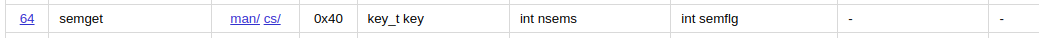

In [ ]:
#include <sys/sem.h>

int semget(key_t key , int nsems , int semflg );

Этой же функцией можно получить доступ к уже существующему семафору, если первым параметром укажем ключ, с которым тот создавался. При создании семафора можно  взять **первый параметр равным нулю**, тогда система сама сгенерирует нужный ключ, отличный от ключей семафоров, которые уже существуют в системе. 

**Вторым параметром** указывается количество элементов в массиве семафоров. Если мы создаем только один семафор (один элемент в массиве), то вторым параметром следует взять значение 1. 

**Третий параметр** – это режим создания. Он такой же как у файлов, т.е. берется число 0666 (в восьмеричной системе счисления). Кроме того, берется константа **IPC_CREAT=512**. Если процесс создания семафора закончится удачно, то функция возвратит уникальный номер семафора (дескриптор), который мы и будем в дальнейшем использовать. В противном случае будет возвращено отрицательное значение.

Для работы с семафором используется системный вызов **semctl**. Его номер 66. 

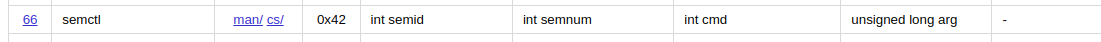

In [ ]:
#include <sys/sem.h>

int semctl(int semid, int semnum, int op, ...);

Эта функция может выполнять разные действия над семафором, в том числе она используется для инициализации семафора. 

**Первым параметром** является дескриптор семафора. 

**Второй параметр** - это индекс семафора в массиве (дескриптор указывает ведь на массив семафоров). 

**Третий параметр** – это выполняемая команда: 

SETVAL = 16 Устанавливает значение семафора. Эта команда, которая говорит о том, что нужно инициализировать семафор. Последний
параметр функции – адрес целой переменной, значение которой это начальное значение счетчика семафора. У нас это 1.
     

Функцию **semct** можно использовать и для удаления существующего семафора. Первый параметр в этом случае также является дескриптор существующего семафора. Остальные параметры функции равны нулю.

Для управления счетчиком семафора используется системный вызов **semop** с номером 65. 

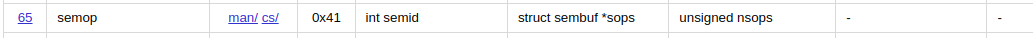


In [ ]:
#include <sys/sem.h>

int semop(int semid, struct sembuf *sops, size_t nsops);

Первым параметром функции является дескриптор семафора. Второй параметр – это адрес структуры, состоящей из трех 16-битовых чисел. Первое число индекс семафора в массиве. У нас это 0. Второе число – шаг изменения счетчика: -1 или 1, в зависимости от того,
входит или выходит процесс из критической области. Третье число у нас будет SEM_UNDO=4096. Третий параметр - индекс семафора в массиве.

Ниже представлена программа, демонстрирующая испорльзование семафора: родительский и дочерний процессы попеременно выводят символ в консоль, используя для этого семафор.

In [ ]:
;;sem.asm
	
format elf64
public _start
include 'func.asm'

section '.data' writable
   
   val dq 1
   s1 db '1234', 0xa, 0
   
   sm1 dw 0, -1, 4096 
   sm2 dw 0, 1, 4096   
	
	
section '.bss' writable
	
	buffer rb 100
	
	ids  rq 1
	
	place rb 1
	
section '.text' executable
	
_start:

    ;;Создаем семафор
    mov rdi, 0
    mov rsi, 1
    mov rdx, 438 ;;0o666
    or rdx, 512
    mov rax, 64
    syscall
    
    mov [ids], rax
    
    ;;Переводим семафор в состояние готовности
    mov rdi, [ids] ;дескриптор семафора
    mov rsi, 0     ;индекс в массиве
    mov rdx, 16    ;выполняемая команда
    mov r10, val   ;начальное значение
    mov rax, 66
    syscall
    
    ;;Создаем дочерний процесс
    mov rax, 57
    syscall
    
    cmp rax, 0
    jne .parent
    
    mov al, 'b'
    mov [place], al
    jmp .cont
    
    .parent:
    mov al, 'a'
    mov [place], al
    
    
.cont:
    mov r9, 5
    .loop:
    ;;Запираем семафор
    mov rdi, [ids]
    mov rsi, sm1
    mov rdx,0
    mov rax, 65
    syscall
    
    mov al, [place]
    mov [buffer], al
    mov rsi, buffer
    call print_str
    
    ;;Открываем семафор
    mov rdi, [ids]
    mov rsi, sm2
    mov rdx,0
    mov rax, 65
    syscall
    
    call input_keyboard
    
    dec r9
    cmp r9, 0
    jne .loop
    call exit

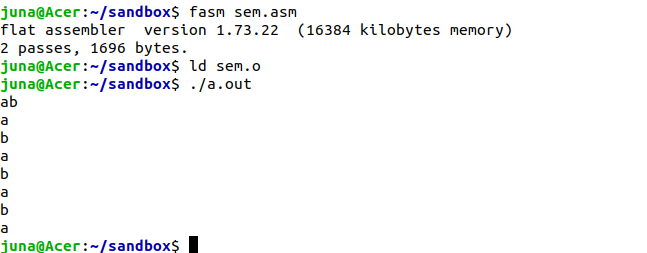